In [96]:
from pathlib import Path
import sys


here = Path.cwd()
candidates = [here] + list(here.parents)
for p in candidates:
    if (p / "Code").is_dir():
        sys.path.insert(0, str(p))
        break
else:
    raise RuntimeError("Couldn't find a 'Code' folder in this project.")


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd


from Code.PINN import create_network_model, u, compute_loss, g_trial_tf, make_train_step, compute_MSE
from Code.functions import euler, analytical_u

import random

def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

import seaborn as sns 
sns.set_theme(style="white", font_scale=1.3)
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["figure.dpi"] = 200
plt.rcParams.update({
    "savefig.dpi": 200,
    "savefig.bbox": "tight"
})


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
N_points = 1000  # Number of collocation points (x, t) in the domain
epochs = 3000  # Number of training epochs

T_final = 0.5 
x_samples = np.random.uniform(0.0, 1.0, N_points)
t_samples = np.random.uniform(0.0, T_final, N_points)
X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)


In [73]:
#WIDTH TEST
widths = [20, 50, 100, 150, 200, 250]
seeds = [0, 1, 2, 3, 4]  

epochs = 3000
results_width_seed = []

for w in widths:
    print(f"\n=== Width: {w} ===")
    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)

        # Build model for this width + seed
        model = create_network_model(layers=[w], activation='tanh')
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        train_step = make_train_step(model, optimizer, compute_loss)

        # Train
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"    Epoch {epoch}: loss = {loss.numpy():.3e}")

        mse = compute_MSE(model, T_final=T_final)
        results_width_seed.append((w, seed, float(loss.numpy()), mse))

# Turn into DataFrame
df_ws = pd.DataFrame(results_width_seed,
                     columns=["Width", "Seed", "Residual loss", "MSE"])

# Aggregate over seeds: mean and std
df_width_summary = (
    df_ws
    .groupby("Width")
    .agg(mean_mse=("MSE", "mean"),
         std_mse=("MSE", "std"),
         mean_residual=("Residual loss", "mean"))
    .reset_index()
)

print(df_width_summary)



=== Width: 20 ===
  Seed 0
    Epoch 0: loss = 2.294e+01
    Epoch 500: loss = 1.015e+00
    Epoch 1000: loss = 1.421e-01
    Epoch 1500: loss = 4.726e-02
    Epoch 2000: loss = 2.130e-02
    Epoch 2500: loss = 1.286e-02
  Seed 1
    Epoch 0: loss = 2.020e+01
    Epoch 500: loss = 6.465e-01
    Epoch 1000: loss = 7.266e-02
    Epoch 1500: loss = 2.654e-02
    Epoch 2000: loss = 1.611e-02
    Epoch 2500: loss = 1.102e-02
  Seed 2
    Epoch 0: loss = 2.273e+01
    Epoch 500: loss = 1.019e+00
    Epoch 1000: loss = 1.814e-01
    Epoch 1500: loss = 4.217e-02
    Epoch 2000: loss = 1.784e-02
    Epoch 2500: loss = 1.062e-02
  Seed 3
    Epoch 0: loss = 2.145e+01
    Epoch 500: loss = 9.155e-01
    Epoch 1000: loss = 1.395e-01
    Epoch 1500: loss = 3.971e-02
    Epoch 2000: loss = 1.683e-02
    Epoch 2500: loss = 1.078e-02
  Seed 4
    Epoch 0: loss = 2.159e+01
    Epoch 500: loss = 1.052e+00
    Epoch 1000: loss = 1.485e-01
    Epoch 1500: loss = 5.350e-02
    Epoch 2000: loss = 2.726e-02

In [ ]:
depth_architectures = [
    [200],
    [200, 200],
    [200, 200, 200],
    [200, 200, 200, 200],
]

results_layers = []

for layers in depth_architectures:
    print(f"\n=== Depth experiment: layers={layers}, tanh ===")
    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)
    # Build new model
        model = create_network_model(layers=layers)
    
    # new optimizer for each model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    # Create new train_step bound to this model & optimizer
        train_step = make_train_step(model, optimizer, compute_loss)

    # Train
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

        mse = compute_MSE(model, T_final=T_final)
        results_layers.append((str(layers), float(loss.numpy()), mse))
    #print(f"Final residual loss: {loss.numpy():.3e}, MSE vs exact: {mse:.3e}")

df_layers = pd.DataFrame(results_layers, columns=["Architecture", "Residual loss", "MSE"])

# Aggregate over seeds: mean and std
df_depth_summary = (
    df_layers
    .groupby("Architecture")
    .agg(mean_mse=("MSE", "mean"),
         std_mse=("MSE", "std"),
         mean_residual=("Residual loss", "mean"))
    .reset_index()
)

print(df_depth_summary)


=== Depth experiment: layers=[200], tanh ===
  Seed 0
  Epoch 0: loss = 2.125e+01
  Epoch 500: loss = 1.504e-01
  Epoch 1000: loss = 1.559e-02
  Epoch 1500: loss = 9.678e-03
  Epoch 2000: loss = 6.996e-03
  Epoch 2500: loss = 5.525e-03
  Seed 1
  Epoch 0: loss = 2.064e+01
  Epoch 500: loss = 1.058e-01
  Epoch 1000: loss = 1.128e-02
  Epoch 1500: loss = 5.423e-03
  Epoch 2000: loss = 3.581e-03
  Epoch 2500: loss = 4.903e-02
  Seed 2
  Epoch 0: loss = 2.224e+01
  Epoch 500: loss = 2.542e-01
  Epoch 1000: loss = 1.211e-02
  Epoch 1500: loss = 1.878e-02
  Epoch 2000: loss = 1.723e-02
  Epoch 2500: loss = 2.963e-03
  Seed 3
  Epoch 0: loss = 2.238e+01
  Epoch 500: loss = 1.882e-01
  Epoch 1000: loss = 1.677e-02
  Epoch 1500: loss = 8.483e-03
  Epoch 2000: loss = 5.051e-03
  Epoch 2500: loss = 3.573e-03
  Seed 4
  Epoch 0: loss = 2.108e+01
  Epoch 500: loss = 1.198e-01
  Epoch 1000: loss = 1.601e-02
  Epoch 1500: loss = 8.941e-03
  Epoch 2000: loss = 5.744e-03
  Epoch 2500: loss = 4.027e-03

In [ ]:
#ACTIVATION TEST

activations = ['tanh', 'sigmoid', 'relu', 'swish']

results_activations = []
epochs = 3000

# Activation function test
for act in activations:
    print(f"\n=== Activation experiment: {act}, layers=[200, 200] ===")
    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)

    # Create model with the activation
        model = create_network_model(layers=[200,200], activation=act)

    # New optimizer per model
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

     # new train_step bound to this model & optimizer
        train_step = make_train_step(model, optimizer, compute_loss)

    # Training loop
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

    # Compute accuracy
        mse = compute_MSE(model, T_final=T_final)

        results_activations.append((act, float(loss.numpy()), mse))

    #print(f"Final residual loss: {loss.numpy():.3e}, MSE vs exact: {mse:.3e}")

df_act = pd.DataFrame(results_activations, columns=["Activation", "Residual loss", "MSE"])
print(df_act)



=== Activation experiment: tanh, layers=[200, 200] ===
  Seed 0
  Epoch 0: loss = 2.171e+01
  Epoch 500: loss = 1.248e-03
  Epoch 1000: loss = 3.858e-04
  Epoch 1500: loss = 2.884e-04
  Epoch 2000: loss = 2.156e-04
  Epoch 2500: loss = 1.920e-02
  Seed 1
  Epoch 0: loss = 2.236e+01
  Epoch 500: loss = 1.593e-03
  Epoch 1000: loss = 3.893e-04
  Epoch 1500: loss = 1.797e-04
  Epoch 2000: loss = 1.350e-04
  Epoch 2500: loss = 1.613e-04
  Seed 2
  Epoch 0: loss = 2.231e+01
  Epoch 500: loss = 3.721e-03
  Epoch 1000: loss = 4.232e-04
  Epoch 1500: loss = 1.877e-03
  Epoch 2000: loss = 7.180e-03
  Epoch 2500: loss = 2.597e-04
  Seed 3
  Epoch 0: loss = 2.212e+01
  Epoch 500: loss = 1.947e-03
  Epoch 1000: loss = 3.565e-04
  Epoch 1500: loss = 1.839e-04
  Epoch 2000: loss = 4.299e-03
  Epoch 2500: loss = 1.788e-02
  Seed 4
  Epoch 0: loss = 2.150e+01
  Epoch 500: loss = 1.244e-03
  Epoch 1000: loss = 3.577e-04
  Epoch 1500: loss = 2.016e-04
  Epoch 2000: loss = 2.594e-04
  Epoch 2500: loss =

In [ ]:
eta = [0.0001, 0.001, 0.01, 0.1, 1.0]
epochs = 3000

results_eta = []

# Learning rate test
for learning_rate in eta:
    print(f"\n=== Learning rate experiment: eta={learning_rate}, layers=[200,200], swish ===")
    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)
    # Create model
        model = create_network_model(layers=[200,200], activation='swish')

    # New optimizer per model
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # 
        train_step = make_train_step(model, optimizer, compute_loss)

    # Teaining loop
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

    # 5. Compute accuracy
        mse = compute_MSE(model, T_final=T_final)

        results_eta.append((learning_rate, float(loss.numpy()), mse))

    #print(f"Final residual loss: {loss.numpy():.3e}, MSE vs exact: {mse:.3e}")
    
df_eta = pd.DataFrame(results_eta, columns=["Learning rate", "Residual loss", "MSE"])
df_eta_summary = (
    df_eta.groupby("Learning rate")
          .agg(mean_mse=("MSE", "mean"),
               std_mse=("MSE", "std"),
               mean_residual=("Residual loss", "mean"))
          .reset_index()
)

print(df_eta_summary)


=== Learning rate experiment: eta=0.0001, layers=[200,200], swish ===
  Seed 0
  Epoch 0: loss = 2.147e+01
  Epoch 500: loss = 1.045e+01
  Epoch 1000: loss = 8.821e+00
  Epoch 1500: loss = 5.367e+00
  Epoch 2000: loss = 1.597e+00
  Epoch 2500: loss = 1.403e+00
  Seed 1
  Epoch 0: loss = 2.163e+01
  Epoch 500: loss = 1.052e+01
  Epoch 1000: loss = 8.746e+00
  Epoch 1500: loss = 4.968e+00
  Epoch 2000: loss = 1.537e+00
  Epoch 2500: loss = 1.372e+00
  Seed 2
  Epoch 0: loss = 2.163e+01
  Epoch 500: loss = 1.039e+01
  Epoch 1000: loss = 8.507e+00
  Epoch 1500: loss = 4.496e+00
  Epoch 2000: loss = 1.531e+00
  Epoch 2500: loss = 1.375e+00
  Seed 3
  Epoch 0: loss = 2.158e+01
  Epoch 500: loss = 1.048e+01
  Epoch 1000: loss = 8.594e+00
  Epoch 1500: loss = 4.655e+00
  Epoch 2000: loss = 1.566e+00
  Epoch 2500: loss = 1.409e+00
  Seed 4
  Epoch 0: loss = 2.142e+01
  Epoch 500: loss = 1.050e+01
  Epoch 1000: loss = 8.543e+00
  Epoch 1500: loss = 4.055e+00
  Epoch 2000: loss = 1.469e+00
  Epo

In [ ]:
# OPTIMIZER TEST


best_layers = [200,200]   
best_activation = 'swish'  
best_lr = 0.01             



results_optim = []

optimizers_to_test = ["Adam", "RMSProp"]

# Train and evaluate each optimizer
for opt_name in optimizers_to_test:
    print(f"\n=== Optimizer: {opt_name} ===")

    for seed in seeds:
        print(f"  Seed {seed}")
        set_seed(seed)

        # Build model
        model = create_network_model(layers=best_layers,
                                     activation=best_activation)

        # Choose optimizer
        if opt_name == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
        elif opt_name == "RMSProp":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=best_lr)

        # Build train step with fresh model + optimizer
        train_step = make_train_step(model, optimizer, compute_loss)

        # Train
        for epoch in range(epochs):
            loss = train_step(X_train)
            if epoch % 500 == 0:
                print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

        # Evaluate
        mse = compute_MSE(model, T_final=T_final)
        results_optim.append((opt_name, float(loss.numpy()), mse))
        
df_optim = pd.DataFrame(results_optim, columns=["Optimizer", "Residual loss", "MSE"])
print(df_optim)


=== Optimizer: Adam ===
  Seed 0
  Epoch 0: loss = 2.147e+01
  Epoch 500: loss = 3.413e-03
  Epoch 1000: loss = 8.747e-04
  Epoch 1500: loss = 5.557e-04
  Epoch 2000: loss = 3.379e-04
  Epoch 2500: loss = 2.915e-04
  Seed 1
  Epoch 0: loss = 2.163e+01
  Epoch 500: loss = 2.532e-03
  Epoch 1000: loss = 1.063e-03
  Epoch 1500: loss = 1.389e-03
  Epoch 2000: loss = 2.358e-04
  Epoch 2500: loss = 3.077e-02
  Seed 2
  Epoch 0: loss = 2.163e+01
  Epoch 500: loss = 4.451e-03
  Epoch 1000: loss = 2.309e-03
  Epoch 1500: loss = 3.604e-04
  Epoch 2000: loss = 4.530e-04
  Epoch 2500: loss = 1.340e-04
  Seed 3
  Epoch 0: loss = 2.158e+01
  Epoch 500: loss = 1.652e-03
  Epoch 1000: loss = 6.635e-04
  Epoch 1500: loss = 4.184e-04
  Epoch 2000: loss = 2.936e-04
  Epoch 2500: loss = 2.101e-04
  Seed 4
  Epoch 0: loss = 2.142e+01
  Epoch 500: loss = 1.817e-03
  Epoch 1000: loss = 6.169e-04
  Epoch 1500: loss = 2.764e-04
  Epoch 2000: loss = 1.648e-04
  Epoch 2500: loss = 1.270e-04

=== Optimizer: RMSP

In [ ]:
N_points_list = [2000, 5000, 10000, 15000]  

results_npoints = []

epochs = 3000
best_layers = [200, 200]
best_activation = 'swish'
best_learning_rate = 0.01
T_final = 0.5

# Test different number of training points
for N_points in N_points_list:
    print(f"\n=== N_points = {N_points} ===")

    # Fix the seed 
    set_seed(42)

    # Build new model
    model = create_network_model(
        layers=best_layers,
        activation=best_activation
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
    train_step = make_train_step(model, optimizer, compute_loss)

    # Sample training points
    x_samples = np.random.uniform(0.0, 1.0, N_points)
    t_samples = np.random.uniform(0.0, T_final, N_points)
    X_train = np.stack([x_samples, t_samples], axis=1).astype(np.float32)

    # Train model
    for epoch in range(epochs):
        loss = train_step(X_train)
        if epoch % 500 == 0:
            print(f"  Epoch {epoch}: loss = {loss.numpy():.3e}")

    # Evaluate
    mse = compute_MSE(model, T_final=T_final)
    print(f"Final residual loss: {loss.numpy():.3e}")
    print(f"MSE vs analytical:  {mse:.3e}")

    # Save result
    results_npoints.append((N_points, float(loss.numpy()), mse))

# Make DataFrame
df_npoints = pd.DataFrame(results_npoints,
                          columns=["N_points", "Residual loss", "MSE"])

print(df_npoints)



=== N_points = 2000 ===
  Epoch 0: loss = 2.098e+01
  Epoch 500: loss = 7.229e-03
  Epoch 1000: loss = 6.549e-04
  Epoch 1500: loss = 3.742e-04
  Epoch 2000: loss = 2.413e-04
  Epoch 2500: loss = 1.691e-04
Final residual loss: 1.316e-04
MSE vs analytical:  1.959e-08

=== N_points = 5000 ===
  Epoch 0: loss = 2.147e+01
  Epoch 500: loss = 2.353e-03
  Epoch 1000: loss = 6.720e-04
  Epoch 1500: loss = 5.449e-04
  Epoch 2000: loss = 4.252e-04
  Epoch 2500: loss = 1.119e-02
Final residual loss: 1.146e-04
MSE vs analytical:  2.509e-08

=== N_points = 10000 ===
  Epoch 0: loss = 2.139e+01
  Epoch 500: loss = 1.197e-02
  Epoch 1000: loss = 4.445e-04
  Epoch 1500: loss = 4.554e-03
  Epoch 2000: loss = 5.242e-04
  Epoch 2500: loss = 1.942e-03
Final residual loss: 9.804e-05
MSE vs analytical:  9.229e-09

=== N_points = 15000 ===
  Epoch 0: loss = 2.130e+01
  Epoch 500: loss = 2.799e-03
  Epoch 1000: loss = 7.691e-04
  Epoch 1500: loss = 5.044e-04
  Epoch 2000: loss = 2.697e-02
  Epoch 2500: loss

In [ ]:

#Test for epochs

best_layers = [200, 200]
best_activation = 'swish'
best_learning_rate = 0.01
epochs = 50000
T_final = 0.5


model = create_network_model(
    layers=best_layers,
    activation=best_activation
)

optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
train_step = make_train_step(model, optimizer, compute_loss)

# Training loop

N_points = 10000
x_samples = np.random.uniform(0.0, 1.0, N_points) 
t_samples = np.random.uniform(0.0, T_final, N_points)
X_train = tf.constant(np.stack([x_samples, t_samples], axis=1), dtype=tf.float32)



# training
for epoch in range(epochs):
    loss = train_step(X_train)
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Residual Loss = {loss.numpy():.3e}")




# Compute final MSE vs analytical solution
mse = compute_MSE(model, T_final=T_final)
print(f"\nFinal residual loss: {loss.numpy():.3e}")
print(f"MSE vs analytical:     {mse:.3e}")



Epoch 500/50000, Residual Loss = 2.247e-03
Epoch 1000/50000, Residual Loss = 7.229e-04
Epoch 1500/50000, Residual Loss = 2.822e-04
Epoch 2000/50000, Residual Loss = 1.735e-04
Epoch 2500/50000, Residual Loss = 1.335e-04
Epoch 3000/50000, Residual Loss = 2.213e-03
Epoch 3500/50000, Residual Loss = 6.416e-03
Epoch 4000/50000, Residual Loss = 9.139e-05
Epoch 4500/50000, Residual Loss = 1.744e-04
Epoch 5000/50000, Residual Loss = 7.668e-03
Epoch 5500/50000, Residual Loss = 5.825e-05
Epoch 6000/50000, Residual Loss = 1.260e-03
Epoch 6500/50000, Residual Loss = 6.273e-05
Epoch 7000/50000, Residual Loss = 3.429e-05
Epoch 7500/50000, Residual Loss = 3.020e-05
Epoch 8000/50000, Residual Loss = 2.278e-04
Epoch 8500/50000, Residual Loss = 2.596e-05
Epoch 9000/50000, Residual Loss = 6.018e-03
Epoch 9500/50000, Residual Loss = 4.349e-05
Epoch 10000/50000, Residual Loss = 2.596e-04
Epoch 10500/50000, Residual Loss = 2.986e-05
Epoch 11000/50000, Residual Loss = 1.206e-03
Epoch 11500/50000, Residual Lo

PLOTS

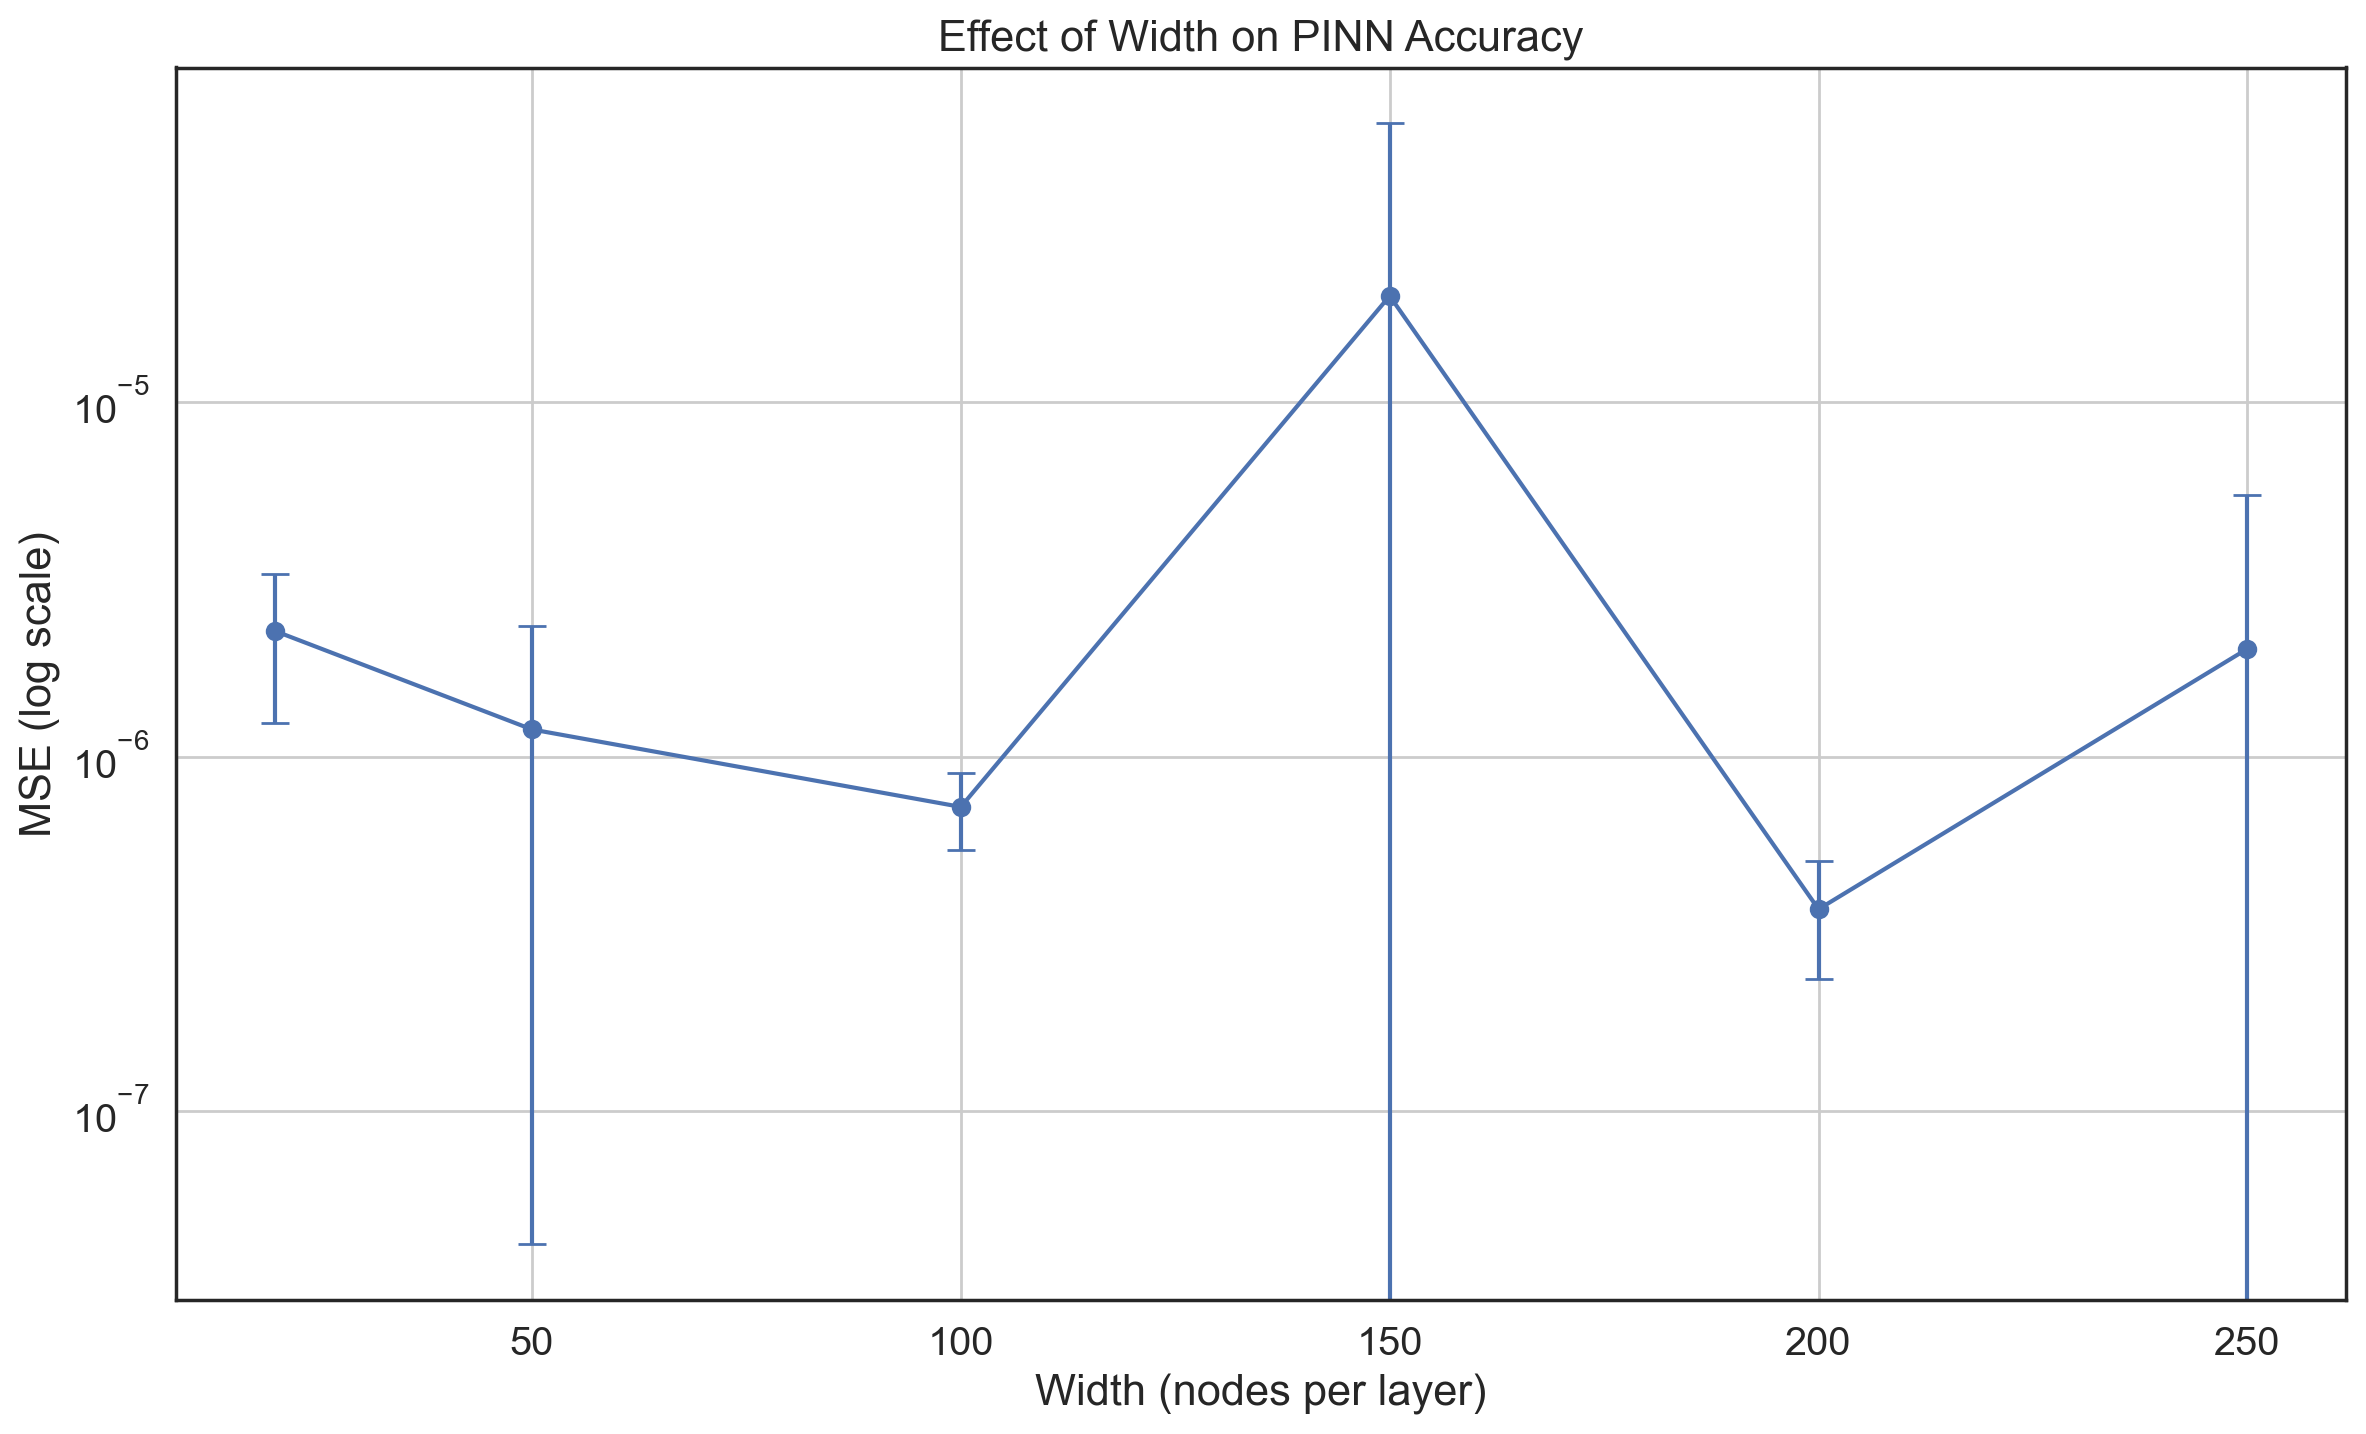

In [97]:
plt.errorbar(df_width_summary['Width'], df_width_summary['mean_mse'], 
             yerr=df_width_summary['std_mse'], fmt='o-', capsize=5)
plt.yscale('log')
plt.xlabel("Width (nodes per layer)")
plt.ylabel("MSE (log scale)")
plt.title("Effect of Width on PINN Accuracy")
plt.grid(True)
plt.show()


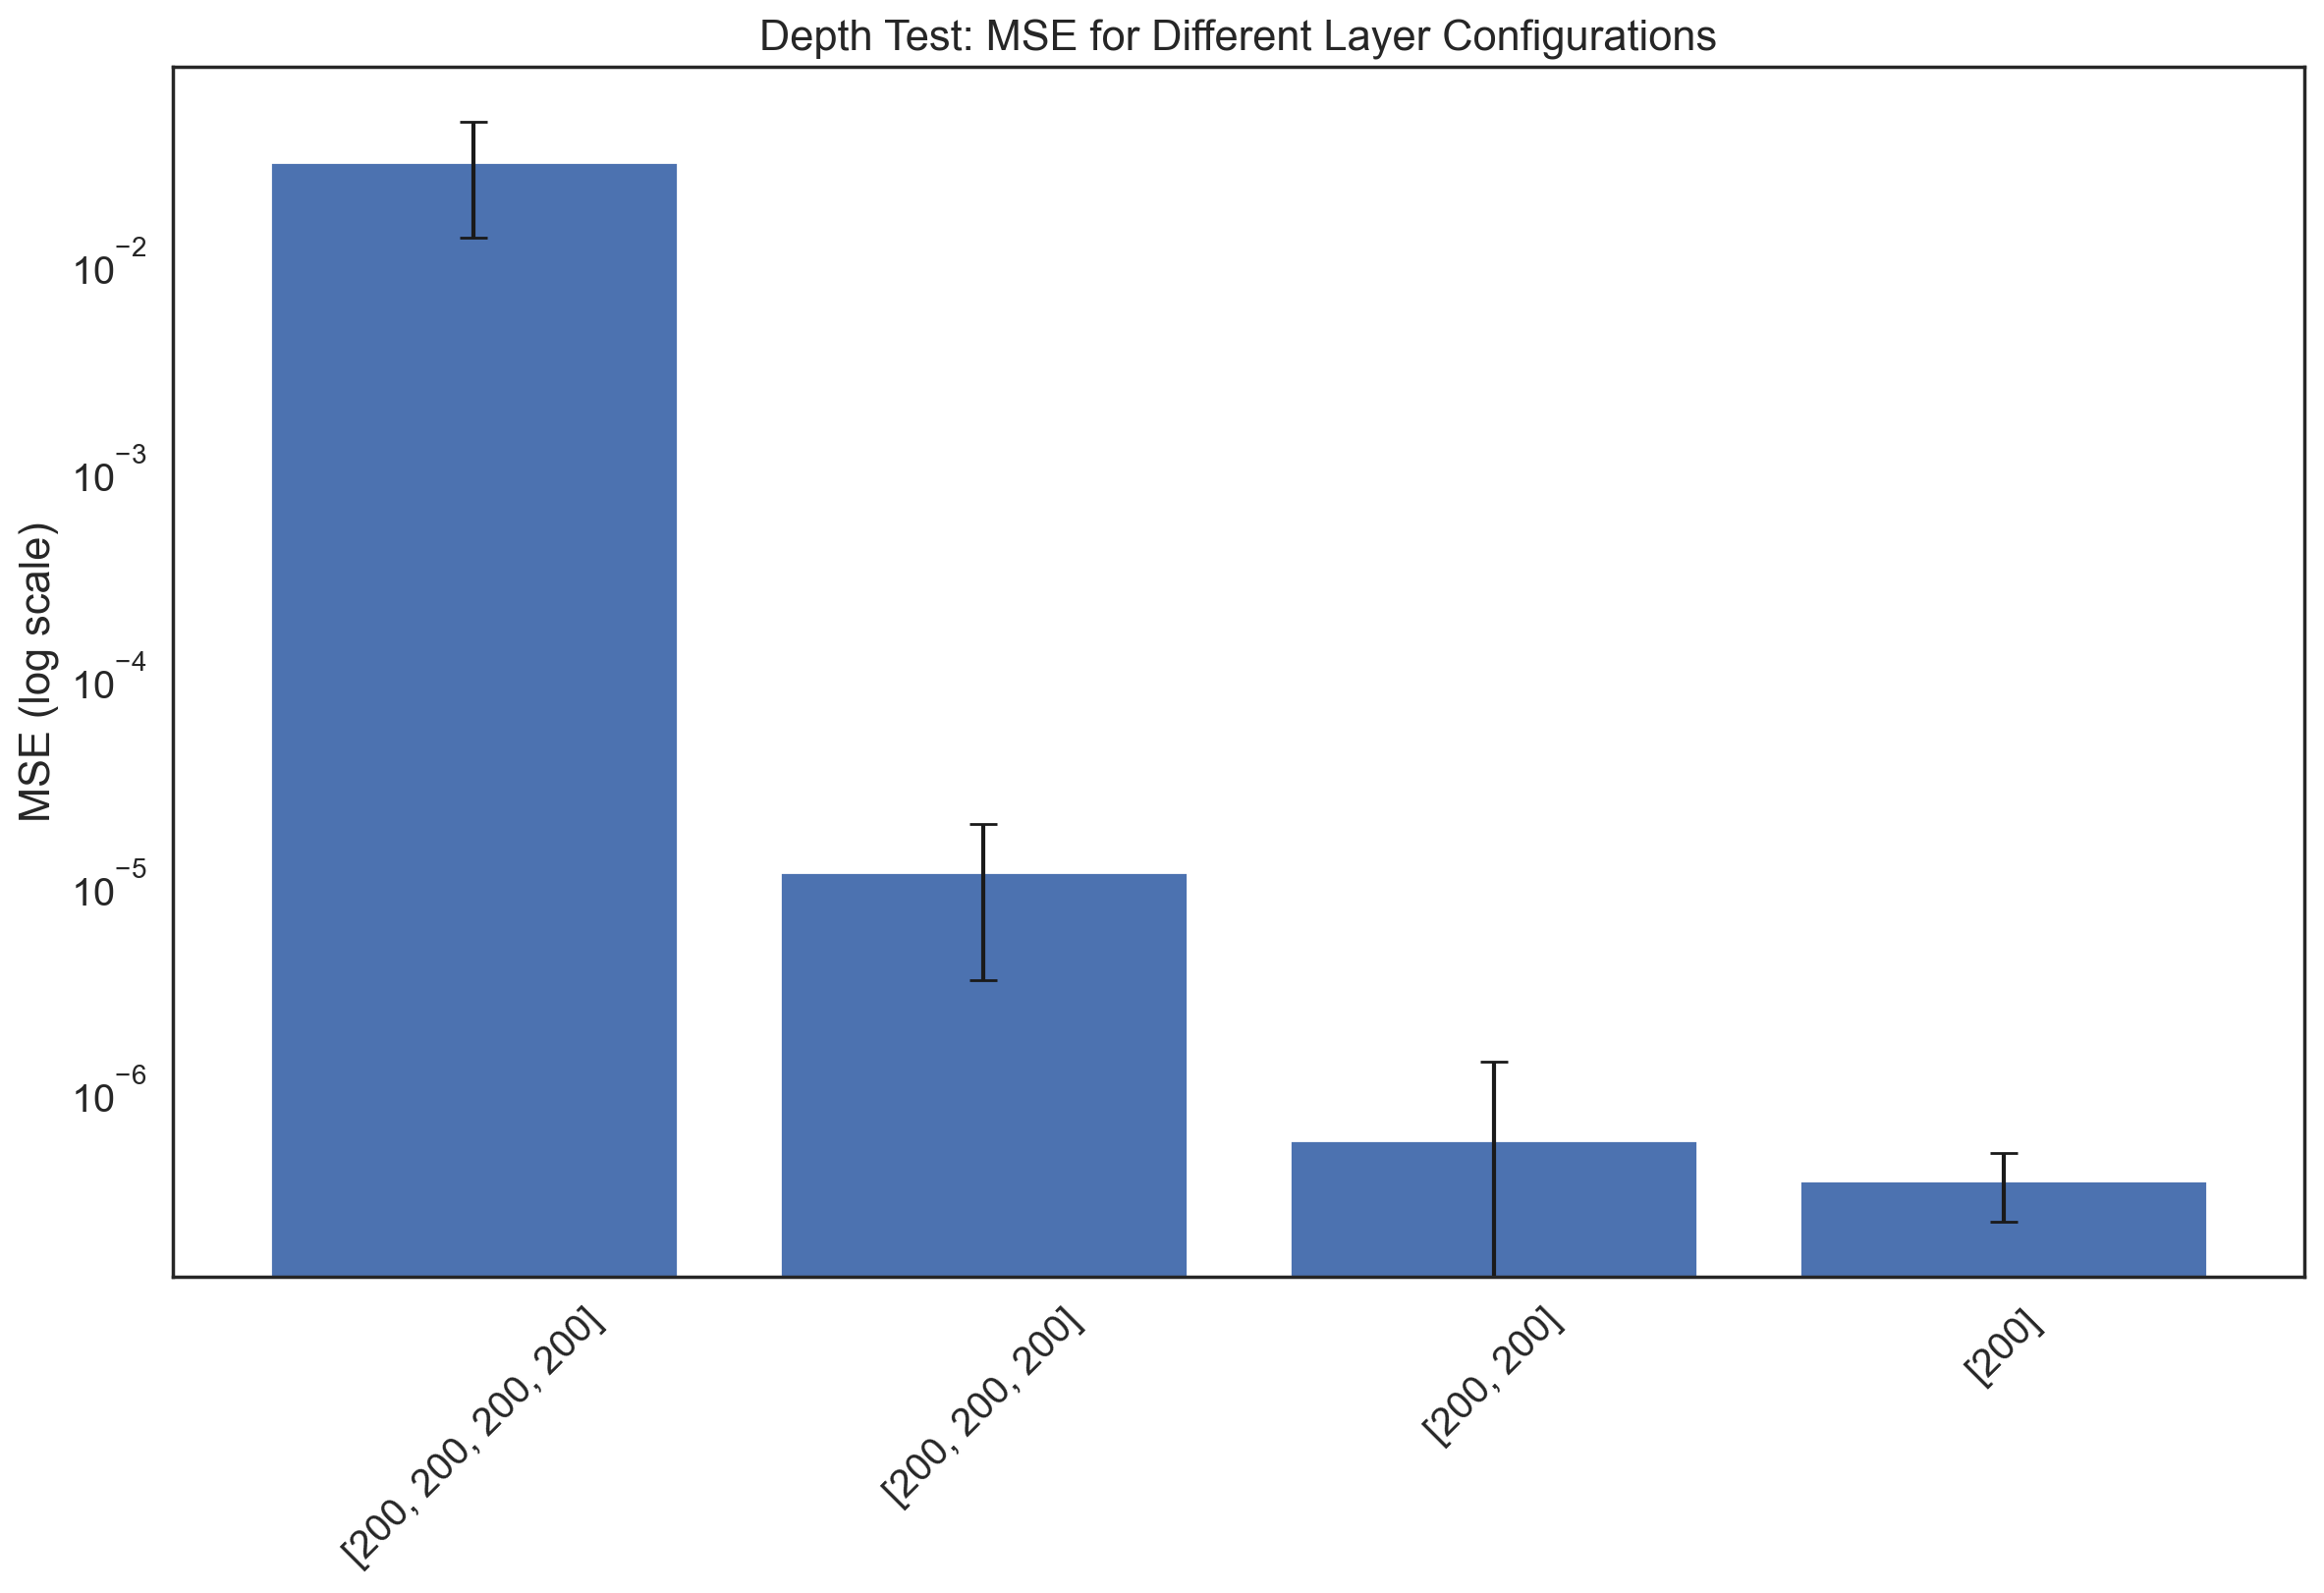

In [98]:
plt.bar(range(len(df_depth_summary)), df_depth_summary['mean_mse'], 
        yerr=df_depth_summary['std_mse'], capsize=5)
plt.xticks(range(len(df_depth_summary)), df_depth_summary['Architecture'], rotation=45)
plt.yscale('log')
plt.title("Depth Test: MSE for Different Layer Configurations")
plt.ylabel("MSE (log scale)")
plt.show()


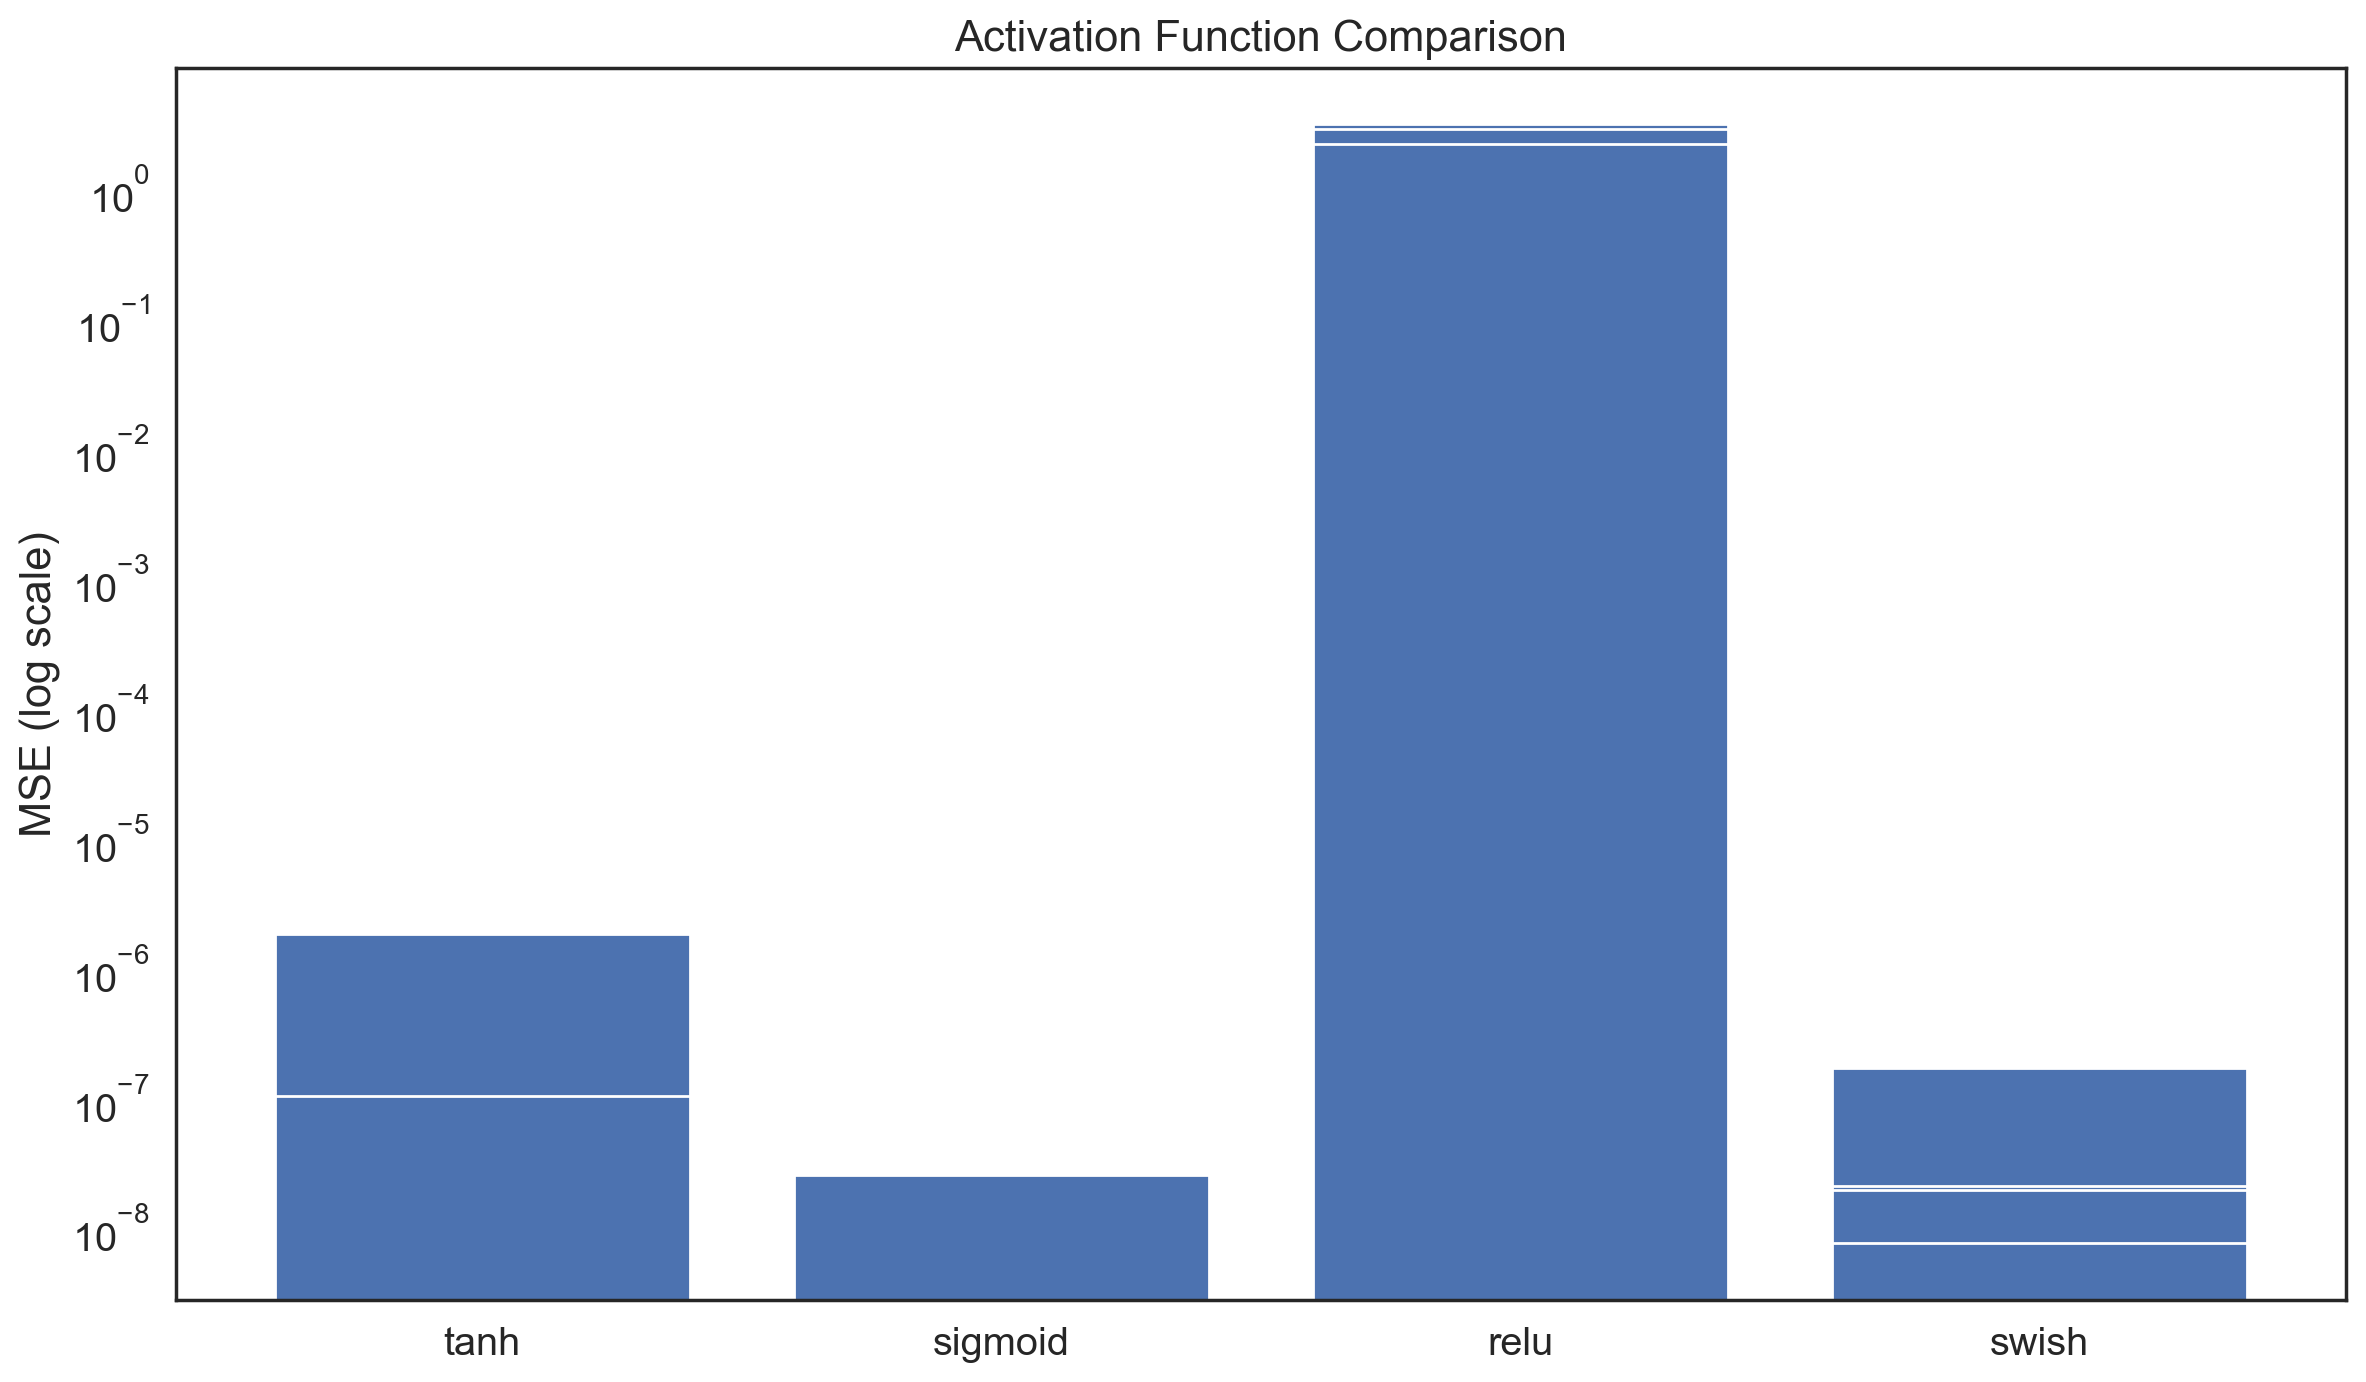

In [105]:
plt.bar(df_act['Activation'], df_act['MSE'])
plt.yscale('log')
plt.title("Activation Function Comparison")
plt.ylabel("MSE (log scale)")
plt.show()


In [106]:
print(df_eta.columns)


Index(['Learning rate', 'Residual loss', 'MSE'], dtype='object')


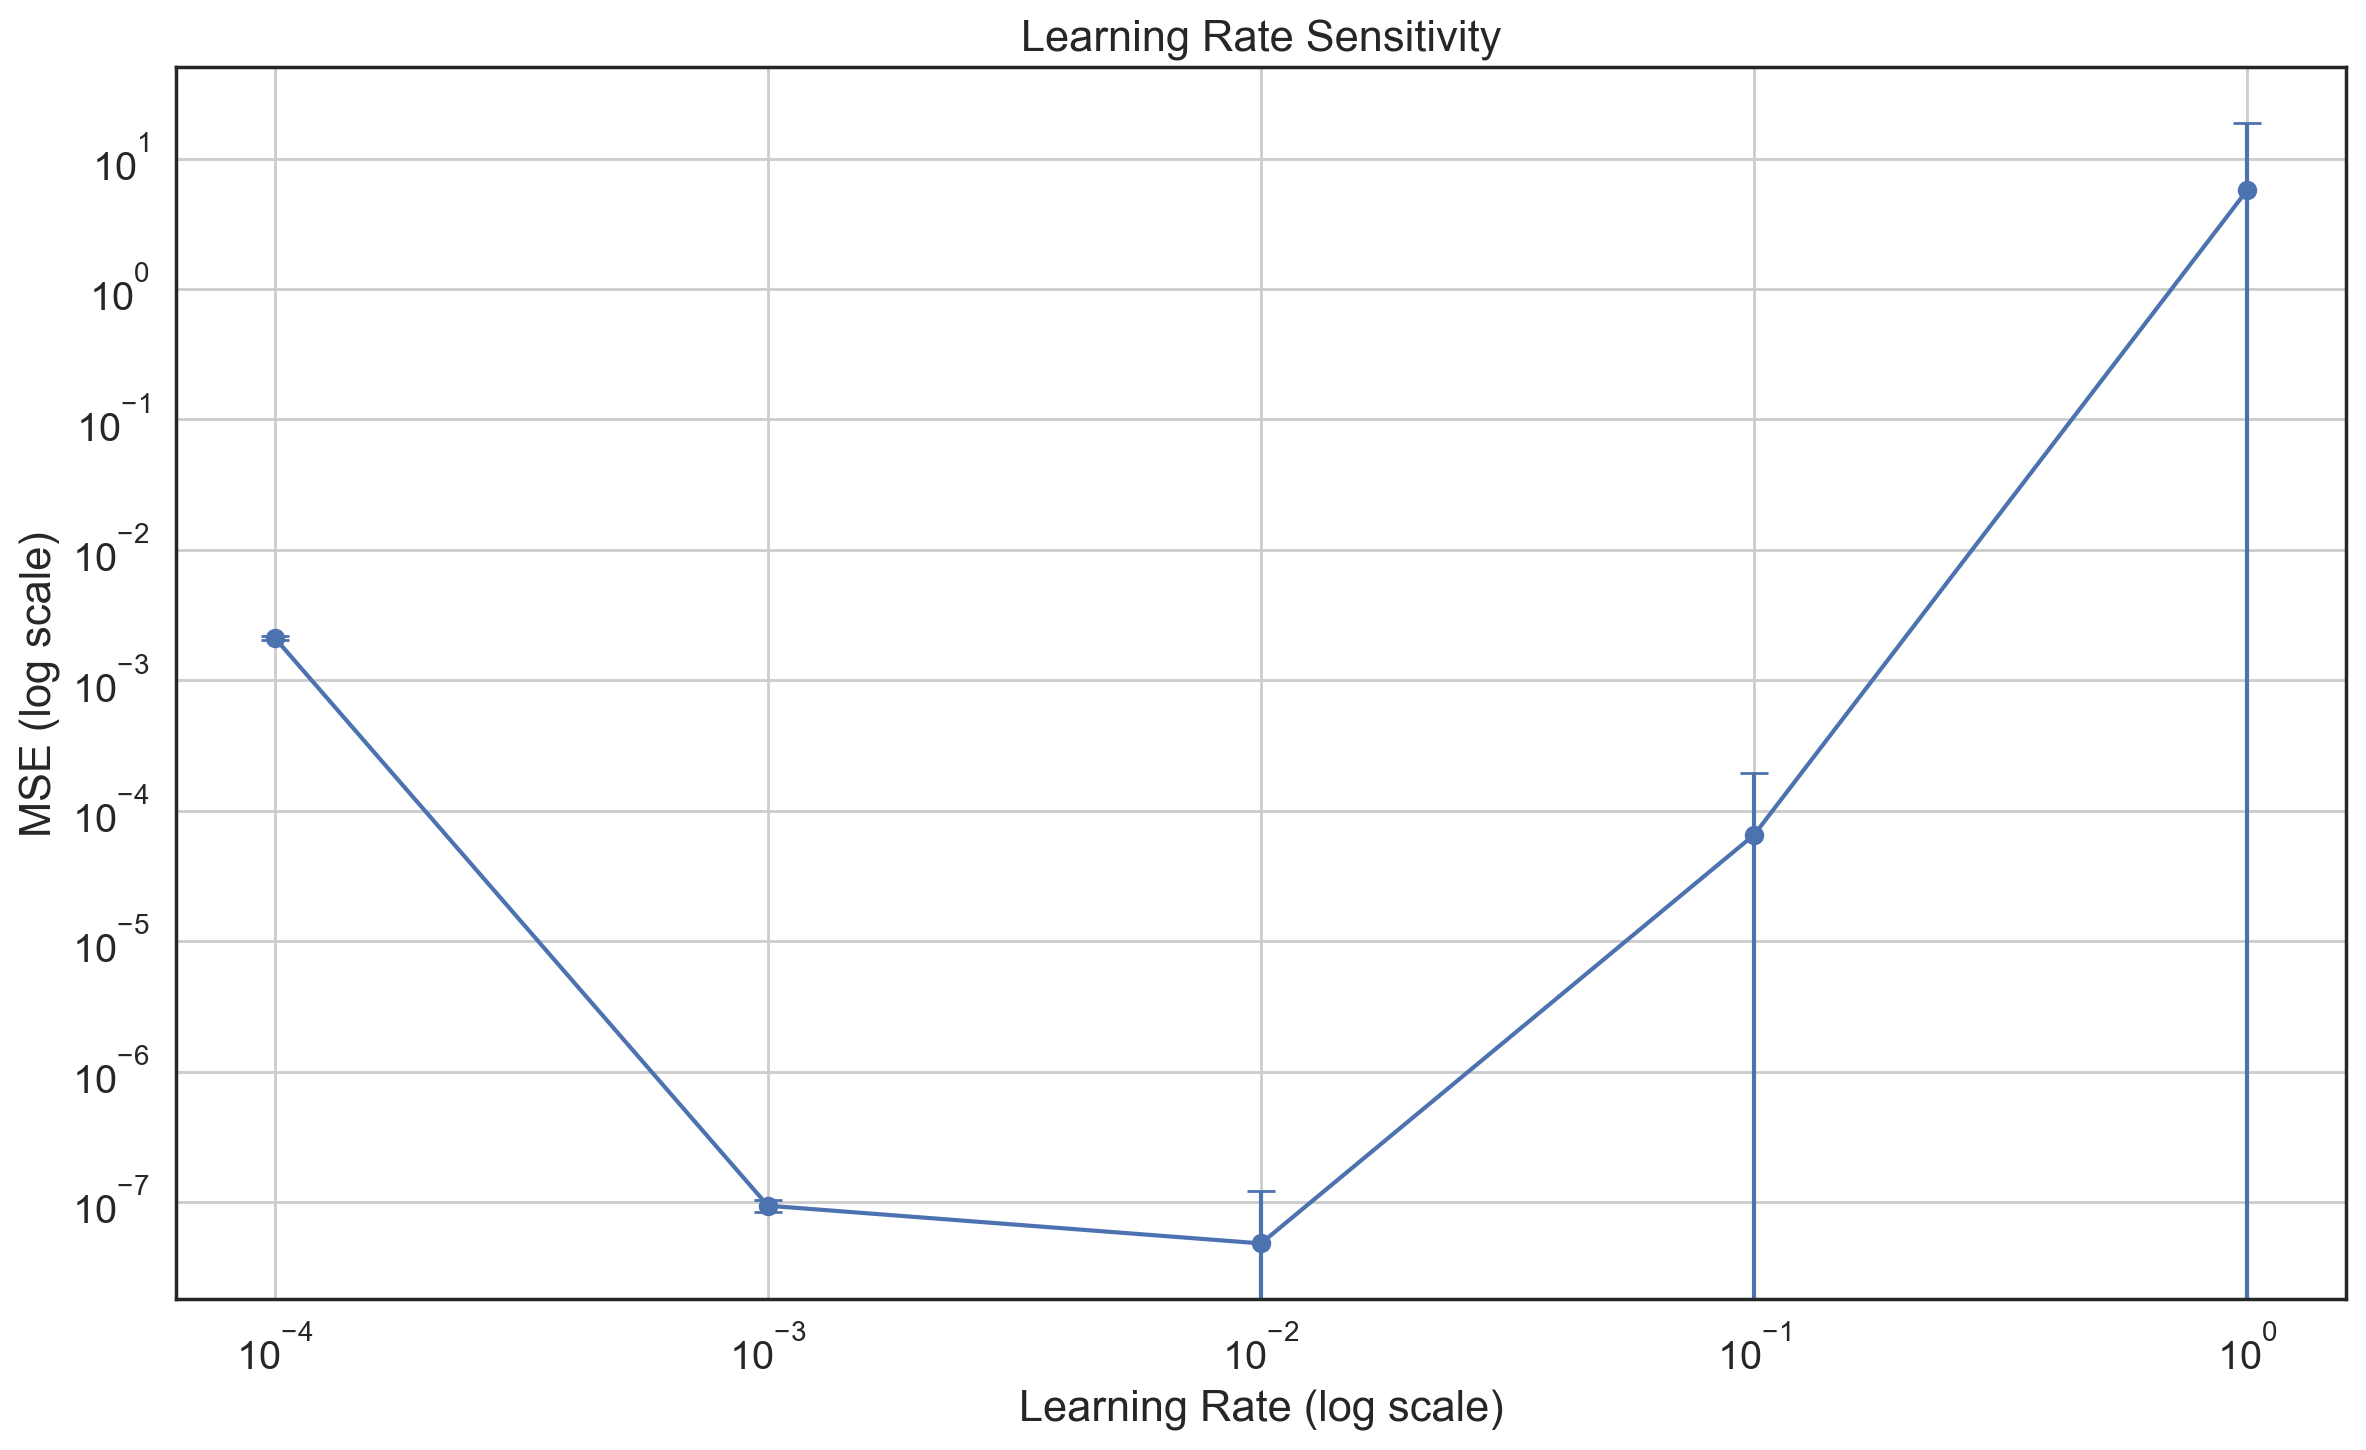

In [107]:
plt.errorbar(df_eta_summary["Learning rate"], df_eta_summary["mean_mse"],
             yerr=df_eta_summary["std_mse"], fmt='o-', capsize=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("MSE (log scale)")
plt.title("Learning Rate Sensitivity")
plt.grid(True)
plt.show()



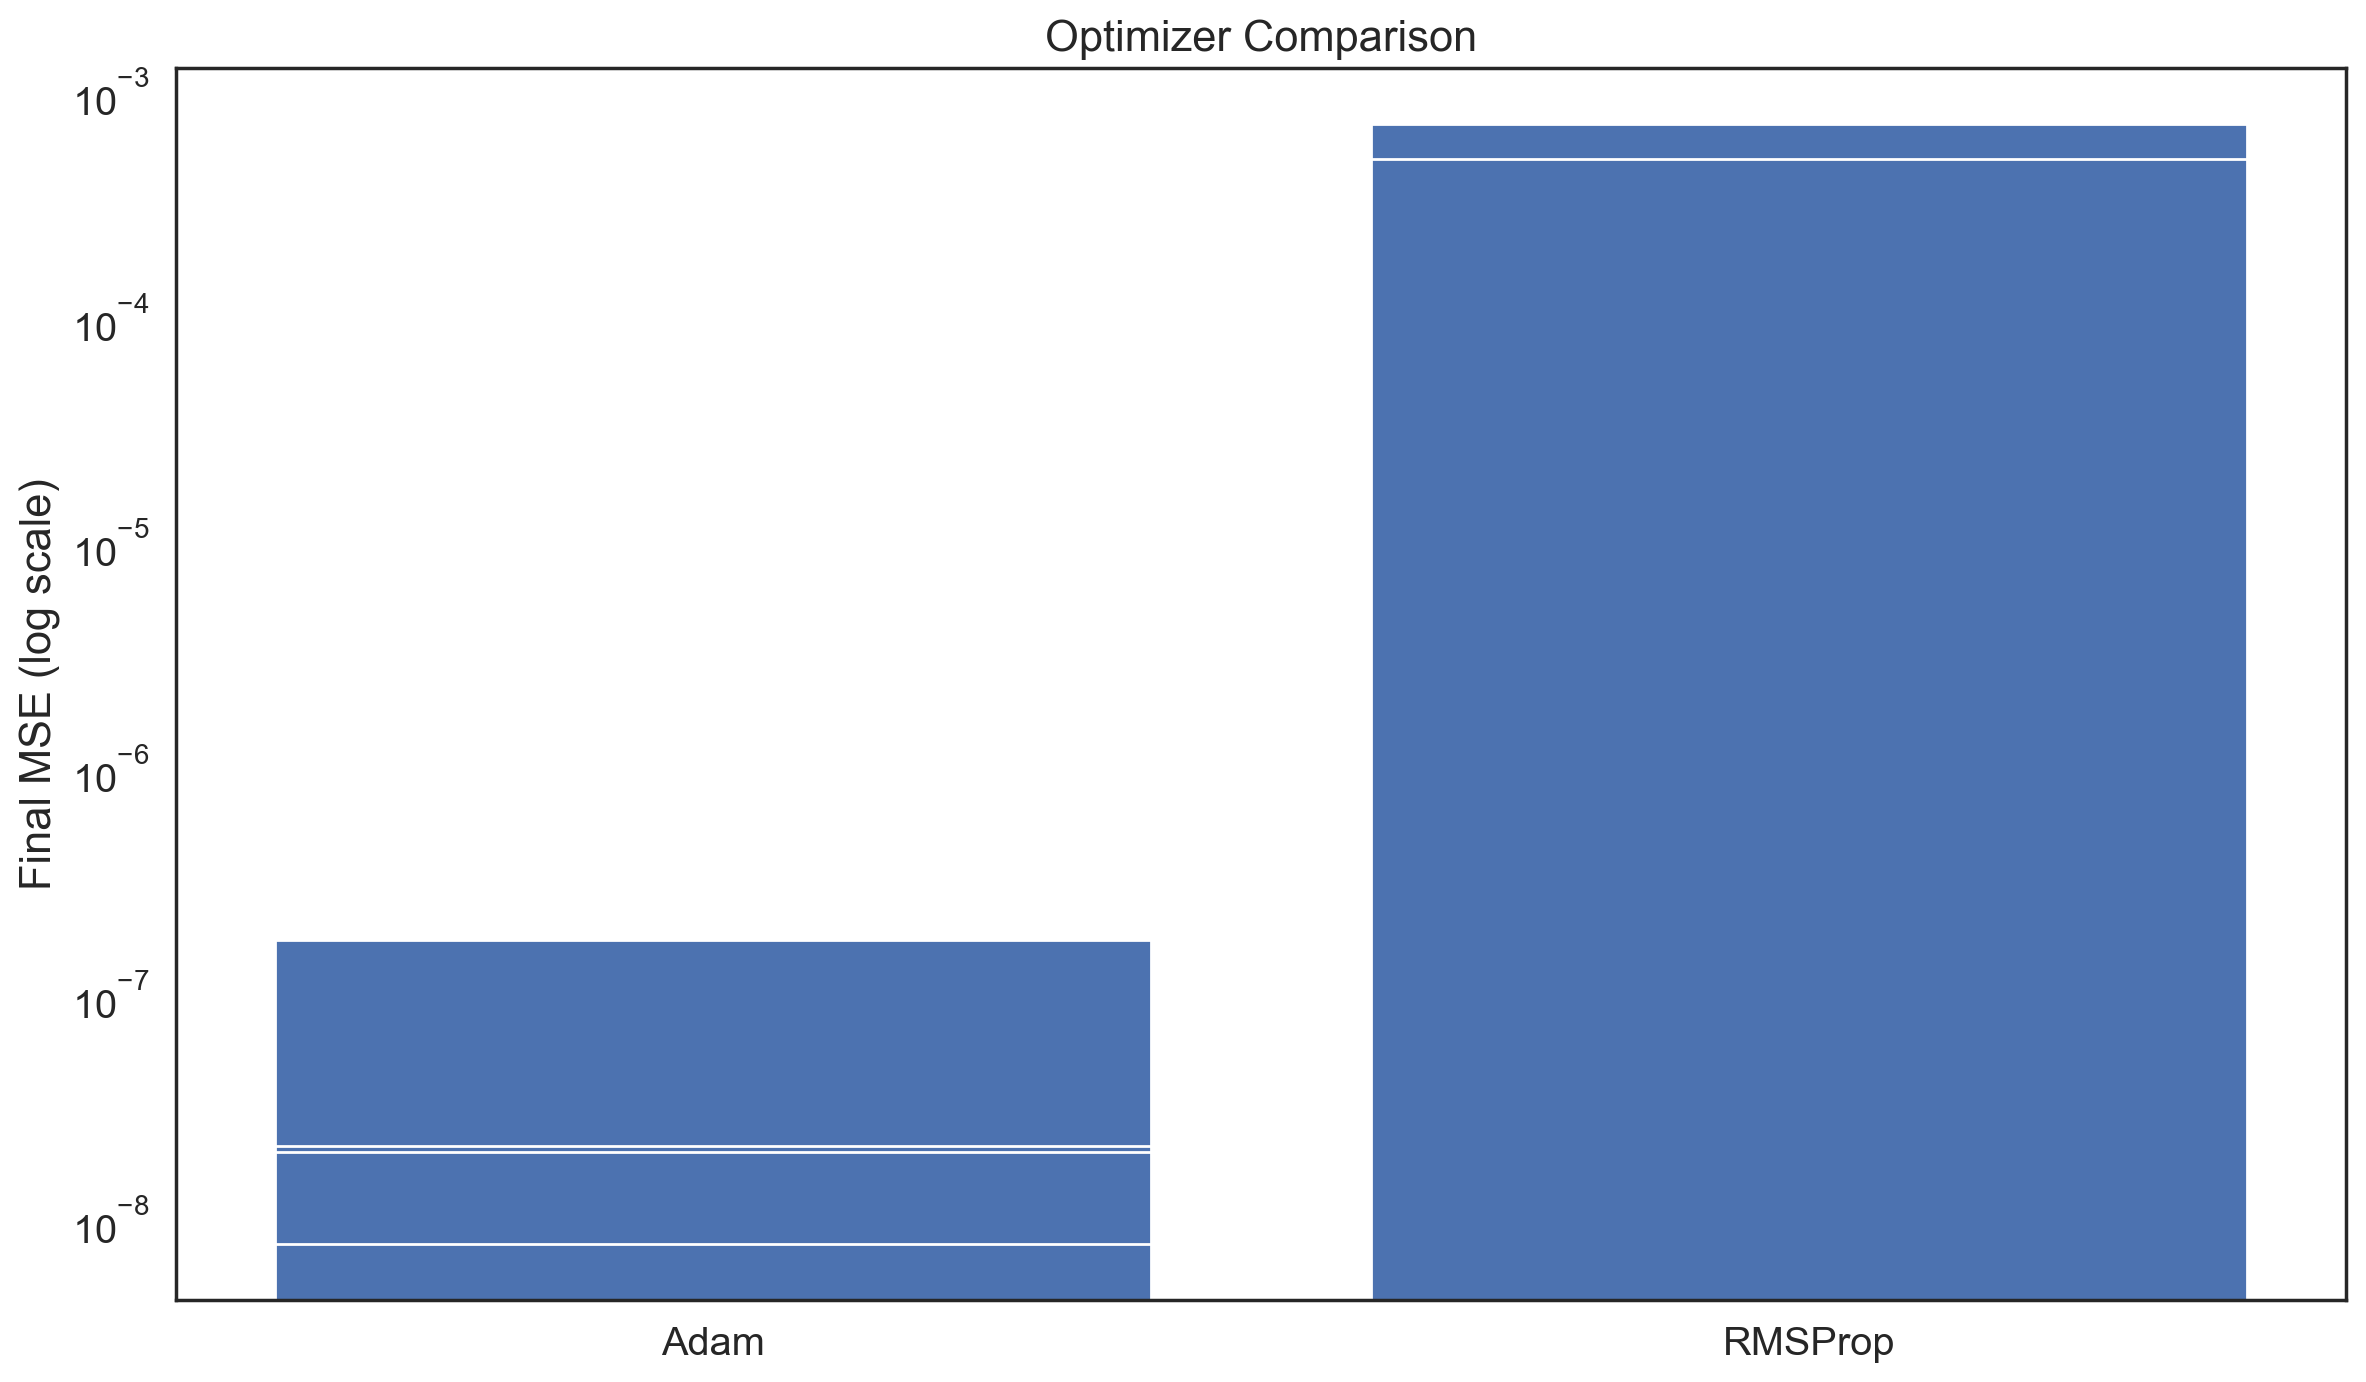

In [108]:
plt.bar(df_optim['Optimizer'], df_optim['MSE'])
plt.yscale('log')
plt.title("Optimizer Comparison")
plt.ylabel("Final MSE (log scale)")
plt.show()


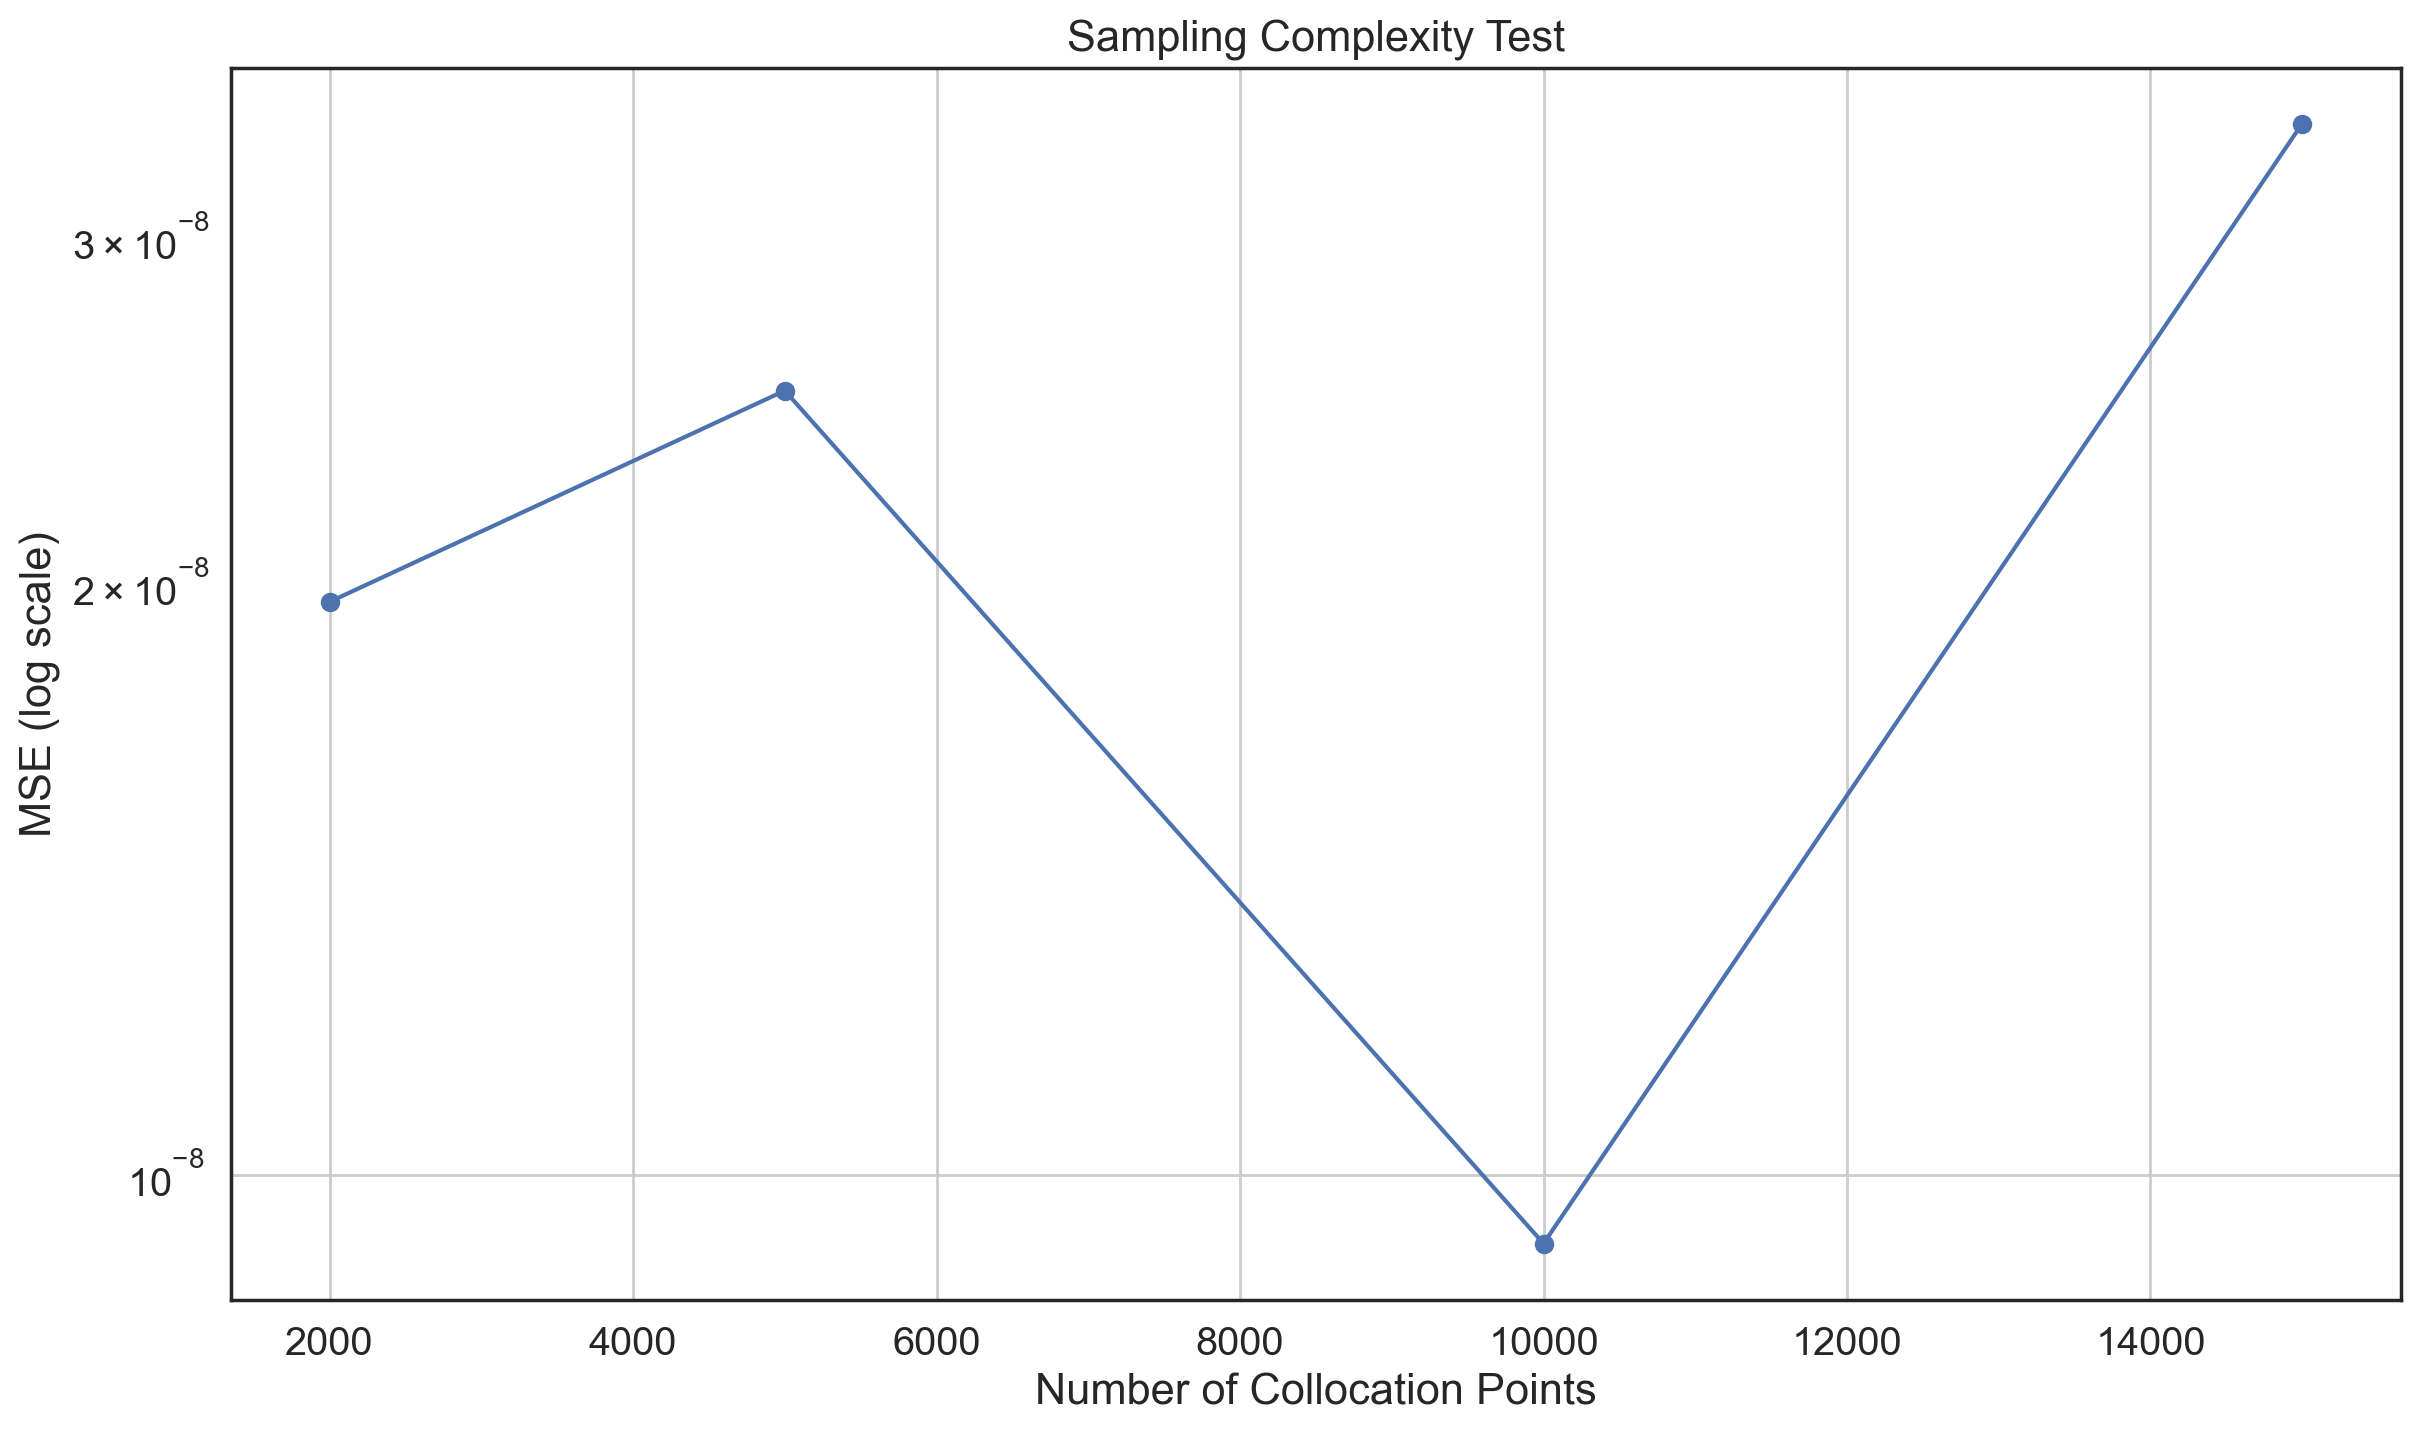

In [109]:
plt.plot(df_npoints['N_points'], df_npoints['MSE'], 'o-')
plt.yscale('log')
plt.xlabel("Number of Collocation Points")
plt.ylabel("MSE (log scale)")
plt.title("Sampling Complexity Test")
plt.grid(True)
plt.show()
